In [2]:
from fastai.vision.all import *
import pdb

import sys
lib_dir = (Path('../Libraries/SBR/lib')).resolve()
if str(lib_dir) not in sys.path: sys.path.insert(0, str(lib_dir))
from config_utils import load_configure
from models import obtain_model, remove_module_dict
from pts_utils import generate_label_map
from models.basic_batch import find_tensor_peak_batch

In [4]:
#use cuda if avaliable, otherwise use cpu --- Not recomended to use CPU it will take a looooong time
device = 'cuda' if torch.cuda.is_available else 'cpu'
defaults.device = torch.device(device)

In [5]:
#load data | file names and landmarks
neuro_list = pd.read_csv("../data/TorontoNeuroFace_cropped_Landmarks.csv", index_col = 0)

#this are the test subjects. Test subjects were randomly selected, you can adjust this to your linking
test_subjects = list(pd.read_csv("../data/test_subjects.txt", index_col=0).Test_Subjects.values)


#test data frame
neuro_list_test = neuro_list[neuro_list['subject_id'].isin(test_subjects)]
#train + val data frame
neuro_list_train_val = neuro_list[~neuro_list['subject_id'].isin(test_subjects)]

#spit train and validation sets and add a column to indicate the group. Val subjects were randomly selected, you can adjust this to your linking
val_subjects = list(pd.read_csv("../data/val_subjects.txt", index_col=0).Val_Subjects.values)
neuro_list_train = neuro_list_train_val[~neuro_list_train_val['subject_id'].isin(val_subjects)].reset_index(drop=True)
neuro_list_train['is_valid'] = 0
neuro_list_val = neuro_list_train_val[neuro_list_train_val['subject_id'].isin(val_subjects)].reset_index(drop=True)
neuro_list_val['is_valid'] = 1
#merge train and val groups 
df = pd.concat([neuro_list_train, neuro_list_val])

cols = list(neuro_list.columns[4:])

In [11]:
#these functions will take a set of landmarks (TensorPoint in FastAI) and generate a heatmap 
#heatmap production is the same as SBR code to keep everything consisten

def _scale(p, s): return 2 * (p / s) - 1
def _descale(p, s): return (0.5*(p+1.))*s 

def heatmap2argmax(heatmap, scale=False):
    if len(heatmap.shape)<4:
        heatmap = heatmap.unsqueeze(0)

    N, C, H, W = heatmap.shape
    index = heatmap.view(N,C,1,-1).argmax(dim=-1)
    pts = torch.cat([index%W, index//W], dim=2)
    
    if scale:
        scale = tensor([W,H], device=heatmap.device)
        pts = _scale(pts, scale)
    
    return pts

class Heatmap(TensorImageBase): 
    "Heatmap tensor, we can use the type to modify how we display things"
    pass

class HeatmapPoint(TensorPoint):
    """
    A class that mimics TensorPoint, but wraps it so
    we'll be able to override `show` methods with
    a different type.
    """
    pass

class HeatmapTransform(Transform):
    """
    A batch transform that turns TensorPoint instances into Heatmap instances,
    and Heatmap instances into HeatmapPoint instances.
    
    Used as the last transform after all other transformations. 
    """
    # We want the heat map transformation to happen last, so give it a high order value
    order=999
    
    def __init__(self, size = 256, downsample = 8, sigma = 4, heatmap_type = 'gaussian', nopoints = False,  **kwargs):
        """
        heatmap_size: Size of the heatmap to be created
        sigma: Standard deviation of the Gaussian kernel
        """
        super().__init__(**kwargs)
        self.sigma = sigma
        self. downsample = downsample
        self.height = size
        self.width = size
        self.heatmap_type = heatmap_type
        self.nopoints = nopoints
    
    def encodes(self, x:TensorPoint):
        # The shape of x is (batch x n_points x 2)
        num_imgs = x.shape[0]
        num_points = x.shape[1]
        
        Heatmaps = np.zeros((num_imgs, num_points+1,self.height//self.downsample, self.width//self.downsample))
        Masks = np.zeros((num_imgs, num_points+1,1,1))
        for b in range(num_imgs):
            #the points come in a range between -1 and 1 we need to transform then to their original cooor system
            points =_descale(x[b], self.height).cpu().numpy()
            #stack a column of 1 to indicate that all landmarks are visible
            pp = np.column_stack((points.reshape(-1,2), np.ones(len(points)).reshape(-1,1)))
            #generate the heatmaps
            heatmaps, mask = generate_label_map(pp.T, self.height//self.downsample, self.width//self.downsample, self.sigma, self.downsample, self.nopoints, self.heatmap_type)
            Heatmaps[b] = heatmaps.transpose((2, 0, 1))
            Masks[b] = mask.transpose((2, 0, 1))
            
        HM= torch.from_numpy(Heatmaps).type(torch.FloatTensor).to(x.device)
        M = torch.from_numpy(Masks).type(torch.BoolTensor).to(x.device)
        
        #pdb.set_trace()
        #return Heatmaps, Mask (mask is used to indicate if a landmark is not visible), and landmarks
        return HM, M, x
    
    def decodes(self, x:Heatmap):
        """
        Decodes a heat map back into a set of points by finding
        the coordinates of their argmax.
        
        This returns a HeatmapPoint class rather than a TensorPoint
        class, so we can modify how we display the output.
        """
       
        xy, scores = find_tensor_peak_batch(x,self.sigma,self.downsample)
        xy = _scale(xy,self.height)
        return xy

In [19]:
#Generate a FastAI datablock that gets an image and landmarks and returns:
# - Image (normalized with Imagenet Stats)
# - Heatmaps
# - Mask
# - Ground Truth landmarks

# Some random transformations are applied to the images including:
# - Random rotation (-10 to +10 deg)
# - Random zoom (-0.9 to 1.15)
# See FastAI for other transformations 

def get_x(x) : 
    return Path('../data/cropped')/x['file_name']

def get_y(x):
    
    val = x[cols].values
    points = torch.from_numpy(np.array(val, dtype=np.float)).view(-1,2)
    return points

dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    splitter= ColSplitter('is_valid'),
    get_x = get_x,
    get_y = get_y,
    #item_tfms = Resize((400,400)),
    batch_tfms = [*aug_transforms(size=(256,256),do_flip=False, min_zoom = 0.9, max_zoom = 1.15, max_warp=0, pad_mode='zeros'), 
                  Normalize.from_stats(*imagenet_stats),
                  HeatmapTransform()
                 ]
    )

In [20]:
#adjust the show functions so that you can see the images + landmarks
@typedispatch
def show_batch(x:TensorImage, y, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        x[i].show(ctx=ctx)   
        _descale(y[-1][i],256).show(ctx=ctx)

def denorm(tensor,mean,std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  
    return TensorImage(tensor)
        
def show_the_results(x, y, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, stats = None):
    ncols = 2
    n = min(len(x[0]), max_n)
    if ctxs is None: ctxs = get_grid(ncols * n, nrows=nrows, ncols=ncols, 
                                     figsize=figsize, title='Target/Prediction')

     
    if stats is None:
        stats = imagenet_stats
    for tctx,pctx,j in zip(ctxs[0::ncols], ctxs[1::ncols], range(n)):
        #pdb.set_trace()
        img = denorm(x[0][j],*stats)
        img.show(ctx=tctx)
        _descale(x[1][2][j],256).cpu().show(ctx=tctx)
        img.show(ctx=pctx)
        TensorPoint(y[1][j][:-1,:]).show(ctx=pctx)

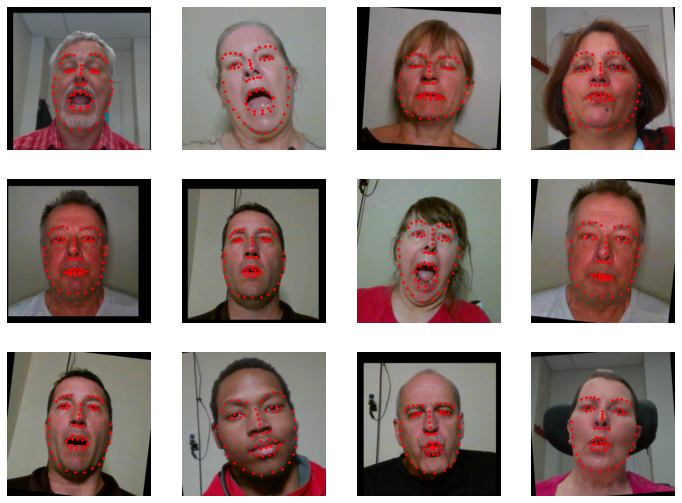

In [21]:
#show one batch of the training set
dls = dblock.dataloaders(df, num_workers=0, bs = 18)
dls.show_batch(max_n=12)

In [25]:
#create a test dataloader with labels
test_dl = dls.test_dl(neuro_list_test, with_labels=True)


In [63]:
# Load the pretrained model
num_pts = 68
conf = r'D:\SBR\configs\Detector.config'
model_config = load_configure(conf, None)
net = obtain_model(model_config, num_pts + 1);
_state_dic = torch.load('../pretrained_models/sbr_model.pth')
net.load_state_dict(remove_module_dict(_state_dic['state_dict']))
net.to(defaults.device);
#Total free model params: 16,716,687

Initialize cpm-vgg16 with configure : Configure(arch='cpm_vgg16', stages=3, dilation=[1], pooling=[True, True, True], downsample=8, argmax=4, pretrained=[True])
vgg16_base use pre-trained model


In [27]:
class WingLoss(nn.Module):
    """
    https://arxiv.org/pdf/1711.06753.pdf
    Refactored implementation from  https://github.com/BloodAxe/pytorch-toolbelt/.
    Supports intermediate supervision.
    """
    def __init__(self, width=5, curvature=0.5):
        super(WingLoss, self).__init__()
        self.w = width
        self.curvature = curvature
        self.c = self.w - self.w * math.log(1 + self.w / self.curvature)

    def __forward_single(self, preds, target):
        preds = TensorBase(preds) #convert tensorImage to tensor 
        target = TensorBase(target) #convert tensorImage to tensor 
        diff_abs = (target - preds).abs()
        loss = diff_abs.clone()

        idx_smaller = diff_abs < self.w
        idx_bigger = diff_abs >= self.w

        loss[idx_smaller] = self.w * torch.log(1 + diff_abs[idx_smaller] / self.curvature)
        loss[idx_bigger] = loss[idx_bigger] - self.c

        return loss.mean()

    def forward(self, preds, target):
        loss = 0
        
        preds = preds[1]

        if not isinstance(preds, tuple):
            preds = (preds,)

        for i in range(len(preds)):
            loss += self.__forward_single(preds[i], target)

        return loss
    
#We will use the WingLoss as loss function 
#https://openaccess.thecvf.com/content_ICCV_2019/papers/Wang_Adaptive_Wing_Loss_for_Robust_Face_Alignment_via_Heatmap_Regression_ICCV_2019_paper.pdf
class AWing(nn.Module):

    def __init__(self, alpha=2.1, omega=14, epsilon=1, theta=0.5):
        super().__init__()
        self.alpha   = float(alpha)
        self.omega   = float(omega)
        self.epsilon = float(epsilon)
        self.theta   = float(theta)

    def forward(self, y_pred , y):
        lossMat = torch.zeros_like(y_pred)
        A = self.omega * (1/(1+(self.theta/self.epsilon)**(self.alpha-y)))*(self.alpha-y)*((self.theta/self.epsilon)**(self.alpha-y-1))/self.epsilon
        C = self.theta*A - self.omega*torch.log(1+(self.theta/self.epsilon)**(self.alpha-y))
        case1_ind = torch.abs(y-y_pred) < self.theta
        case2_ind = torch.abs(y-y_pred) >= self.theta
        lossMat[case1_ind] = self.omega*torch.log(1+torch.abs((y[case1_ind]-y_pred[case1_ind])/self.epsilon)**(self.alpha-y[case1_ind]))
        lossMat[case2_ind] = A[case2_ind]*torch.abs(y[case2_ind]-y_pred[case2_ind]) - C[case2_ind]
        return lossMat

class Loss_weighted(nn.Module):
    def __init__(self, W=10, alpha=2.1, omega=14, epsilon=1, theta=0.5):
        super().__init__()
        self.W = float(W)
        self.Awing = AWing(alpha, omega, epsilon, theta)

    def forward(self, y_pred , y):
        
        y_pred = y_pred[0] #these are the heatmaps out of the model
        targs  = TensorBase(y[0]) #These are the manually generated heatmaps
        M = y[1] #these are the masks 
        
        Loss = 0 
        targs = torch.masked_select(targs, M)
        output = torch.masked_select(TensorBase(y_pred[-1]), M)
        Loss = self.Awing(output,targs)
#         for i in range(len(y_pred)):
#             output  = TensorBase(y_pred[i])#torch.masked_select(TensorBase(y_pred[i]), M)
#             Loss += self.Awing(output,targs)
        #pdb.set_trace()    
        return Loss.mean()

In [36]:

def nmae_argmax(preds, target):
    #FastAI resturn an object of type TensorImage (that has a show property). We need to return that into Tensor (TensorBase)
    #also, we need to descale the ground truth landmarks
    
    return ((TensorBase(preds[1][:,:-1,:])-_descale(TensorBase(target[2]),256)).abs()).mean()


def Normalized_RMSE(preds, targets, selected=None):
    #compute the Root Mean Squared Error between two sets of landmarks (ground truth and model predictions)
    #works in a batch
    
    #FastAI resturn an object of type TensorImage (that has a show property). We need to return that into Tensor (TensorBase)  
    gt = _descale(TensorBase(targets[2]),256).to(device)
    pp = TensorBase(preds[1]).to(device)
    pp = pp[:,:-1,:]
    max_xy,_ = gt.max(dim=1)
    min_xy,_ = gt.min(dim=1)
    diag =  torch.linalg.norm(min_xy-max_xy, dim=1)
    
    if selected:
        gt = gt[:,selected,:]
        pp = pp[:,selected,:]
    nrmse = torch.linalg.norm(gt-pp,dim=2).mean(dim=1).div(diag)*100
    
    return nrmse.mean()
                      

In [64]:
#create the learner
learn = Learner(dls, 
                net, 
                loss_func = Loss_weighted(),
                metrics=[nmae_argmax, Normalized_RMSE])



In [51]:
# test current model with test data
preds = learn.get_preds(dl=test_dl)
nrmse_pretrained = Normalized_RMSE(preds[0],preds[1])
print(f'Normalized Error with Pre-trained model is {nrmse_pretrained.item()} %')

Normalized Error with Pre-trained model is 2.139347791671753 %


Normalized Error with Pre-trained model is 2.084054470062256 %


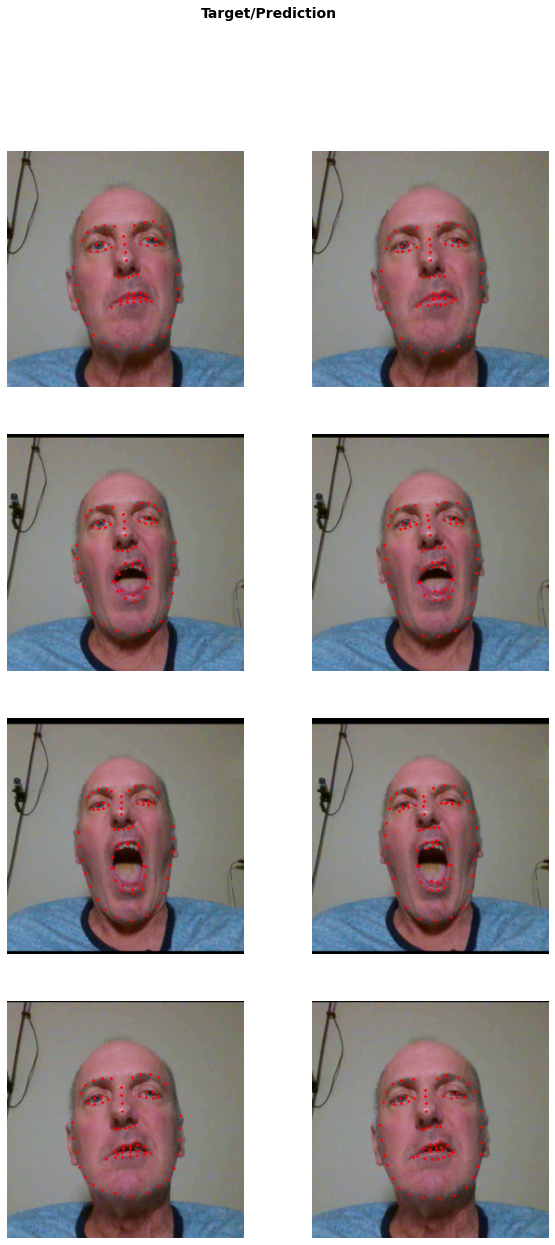

In [65]:
#test a few images from the validation set (showing results)
b = dls.valid.one_batch()
f,d,preds = learn.get_preds(dl=[b], with_decoded=True)
show_the_results(b, preds, max_n=8, figsize=(10,20))
nrmse = Normalized_RMSE(preds, b[1])
print(f'Normalized Error with Pre-trained model is {nrmse.item()} %')

SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=1.4454397387453355e-05)

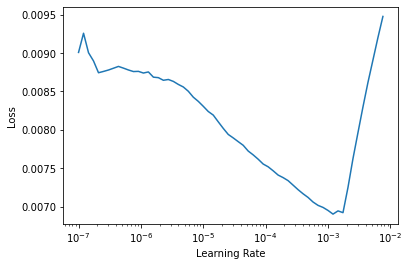

In [40]:
#find learning rate using FastAI 
learn.lr_find()

In [54]:
#Pick best learning rate from curve and train using FastAI
#Training will include early stoping and saving of best model
Path("/models_SBR").mkdir(parents=True, exist_ok=True)
lr = 1e-4
learn.fit_one_cycle(15, lr, 
                   cbs=[EarlyStoppingCallback(monitor='Normalized_RMSE', min_delta=0.01, patience=3),
                       SaveModelCallback(every_epoch=True, fname='/models_SBR/FineTuned_TorontoNeuroFace_Epoch')],
                   )

epoch,train_loss,valid_loss,nmae_argmax,Normalized_RMSE,time
0,0.003617,0.004833,1.817788,1.609891,01:14
1,0.003484,0.005033,1.859840,1.641637,01:15
2,0.003376,0.004827,1.826275,1.620757,01:15
3,0.003214,0.004854,1.872041,1.659654,01:15
4,0.003067,0.004942,1.842955,1.632062,01:15
5,0.002962,0.004862,1.835532,1.627448,01:15
6,0.002822,0.004833,1.838641,1.630924,01:15


No improvement since epoch 3: early stopping


In [55]:
#test new model on testing data
preds = learn.get_preds(dl=test_dl)
nrmse_finetuned = Normalized_RMSE(preds[0],preds[1])
print(f'Test Set - Normalized Error with Pre-trained model is: {nrmse_pretrained.item()} %')
print(f'Test Set - Normalized Error with Fine-tuned model is: {nrmse_finetuned.item()} %')

Test Set - Normalized Error with Pre-trained model is: 2.139347791671753 %
Test Set - Normalized Error with Fine-tuned model is: 1.633420705795288 %


Normalized Error with Fine-Tuned model is 1.5968385934829712 %


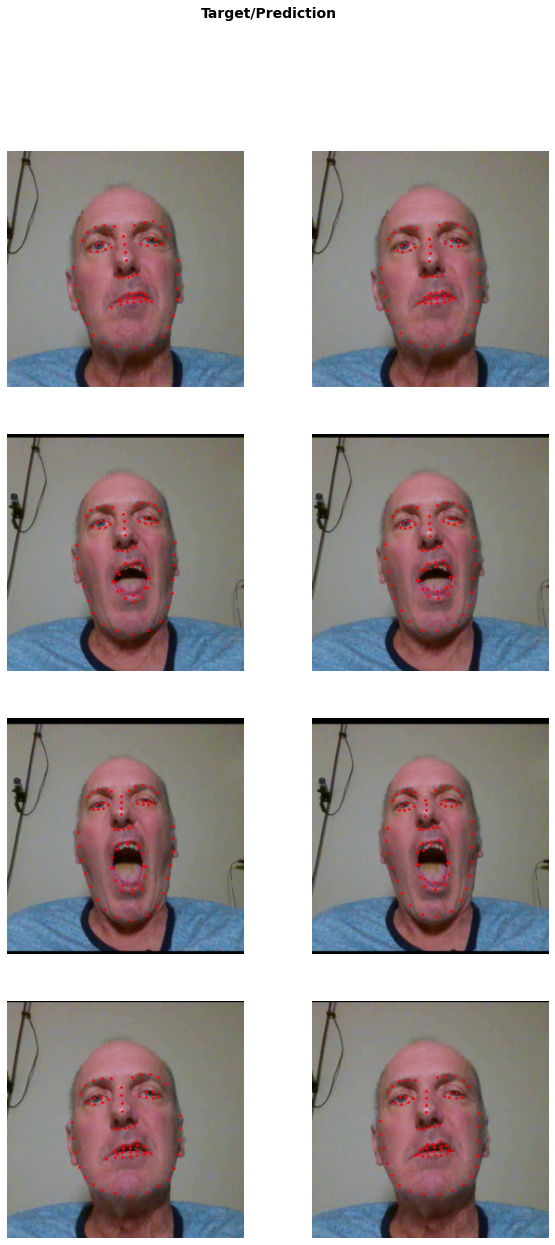

In [58]:
#test a few images from the validation set (showing results)
b = dls.valid.one_batch()
f,d,preds = learn.get_preds(dl=[b], with_decoded=True)
show_the_results(b, preds, max_n=8, figsize=(10,20))
nrmse = Normalized_RMSE(preds, b[1])
print(f'Normalized Error with Fine-Tuned model is {nrmse.item()} %')

## Fin

you can use one of the fine-tuned models as

```python
# Load the pretrained model
num_pts = 68
conf = r'D:\SBR\configs\Detector.config'
model_config = load_configure(conf, None)
net = obtain_model(model_config, num_pts + 1);
_state_dic = torch.load('./models_SBR/FineTuned_TorontoNeuroFace_Epoch_5.pth')
net.load_state_dict(remove_module_dict(_state_dic))
net.to(defaults.device);
```

